# Streaming SODE Inference from YOLO Pose Skeletons

This notebook wires the pretrained SODE action recogniser with a YOLOv11 pose estimator. It streams skeleton detections from a video, buffers the last `window_size` frames, and emits action predictions once enough frames are available.


> **Prerequisites**
> - Install `ultralytics` (e.g. `pip install ultralytics`).
> - Place the YOLOv11 pose weights at `../models/yolo11x-pose.pt` (or update the path below).
> - Ensure `experiments/sode_best.pt` is the checkpoint produced by the training notebook.


In [1]:
from collections import deque
from pathlib import Path
import time

import numpy as np
import torch

from act_rec.model.sode import SODE
from act_rec.params import YoloPoseVideoInferenceParams
from act_rec.labeling import YoloPoseVideoLabeler
from act_rec.preprocessing import preprocess_sequence


In [ ]:
# Paths and runtime configuration
window_size = 64  # Number of skeleton frames per SODE window

project_root = Path("..").resolve()
sode_checkpoint_path = project_root / "experiments" / "sode_best.pt"
yolo_model_path = project_root / "models" / "yolo11x-pose.pt"
video_path = project_root / "data" / "sample2.mp4"  # <-- update to your video path

# Pick the runtime device. The YOLO params expect a string while PyTorch uses torch.device.
if torch.cuda.is_available():
    device = torch.device("cuda")
    yolo_device = "cuda:0"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    yolo_device = "mps"
else:
    device = torch.device("cpu")
    yolo_device = "cpu"

yolo_params = YoloPoseVideoInferenceParams()
yolo_params.device = yolo_device

print(f"Using device: {device} | YOLO device: {yolo_params.device}")
print(f"SODE checkpoint: {sode_checkpoint_path}")
print(f"YOLO weights:    {yolo_model_path}")
print(f"Input video:     {video_path}")


Using device: mps | YOLO device: mps
SODE checkpoint: /Users/nikita/University/CV_PMLDL_DR_Project/experiments/sode_best.pt
YOLO weights:    /Users/nikita/University/CV_PMLDL_DR_Project/models/yolo11x-pose.pt
Input video:     /Users/nikita/University/CV_PMLDL_DR_Project/data/sample2.mp4


In [ ]:
def load_sode_model(checkpoint_path: Path, device: torch.device, window_size: int = 64):
    """Load the pretrained SODE checkpoint and expose an index->label mapping."""
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"SODE checkpoint not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint.get("model")
    if state_dict is None:
        raise KeyError("Checkpoint must contain a 'model' state dict.")

    label_to_idx = checkpoint.get("label_to_idx")
    if label_to_idx is None:
        raise KeyError("Checkpoint must contain 'label_to_idx' mapping.")

    num_classes = len(label_to_idx)
    model = SODE(
        num_class=num_classes,
        num_point=17,
        num_person=1,
        graph="act_rec.graph.coco.Graph",
        in_channels=3,
        T=window_size,
        n_step=3,
        num_cls=4,
    )
    model.load_state_dict(state_dict, strict=True)
    model.to(device)
    model.eval()

    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    return model, idx_to_label


In [ ]:
sode_model, idx_to_label = load_sode_model(sode_checkpoint_path, device, window_size=window_size)
labeler = YoloPoseVideoLabeler(model_path=str(yolo_model_path), params=yolo_params)

preview = [idx_to_label[i] for i in sorted(idx_to_label)[:5]]
print(f"Loaded SODE with {len(idx_to_label)} classes. Example labels: {preview}")


Loaded SODE with 14 classes. Example labels: ['bench_press', 'clean_and_jerk', 'handstand_pushups', 'handstand_walking', 'jump_rope']


In [ ]:
def skeleton_from_result(result):
    """Extract a single-person skeleton (V, 3) array from a YOLO result."""
    keypoints = getattr(result, "keypoints", None)
    if keypoints is None:
        return None
    data = getattr(keypoints, "data", None)
    if data is None or data.shape[0] != 1:
        return None
    return data[0].cpu().numpy()


CONF_THRESHOLD = 0.20


def interpolate_linear_1d(y: np.ndarray, mask_valid: np.ndarray) -> np.ndarray:
    if mask_valid.all():
        return y
    if (~mask_valid).all():
        return np.zeros_like(y)
    x = np.arange(y.shape[0])
    xp = x[mask_valid]
    fp = y[mask_valid]
    return np.interp(x, xp, fp).astype(np.float32)


def interpolate_joints_over_time(xy: np.ndarray, conf: np.ndarray, conf_thr: float) -> np.ndarray:
    xy_interp = xy.copy()
    valid = conf >= conf_thr
    T, V, _ = xy.shape
    for v in range(V):
        mask = valid[:, v]
        for c in range(2):
            xy_interp[:, v, c] = interpolate_linear_1d(xy[:, v, c], mask)
    return xy_interp


def center_and_scale_sequence(joints_xy: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    left_hip, right_hip = 11, 12
    left_sh, right_sh = 5, 6
    pelvis = (joints_xy[:, left_hip, :] + joints_xy[:, right_hip, :]) / 2.0
    pelvis_valid = np.isfinite(pelvis).all(axis=1)
    if pelvis_valid.any():
        pelvis_ref = pelvis[pelvis_valid][0]
    else:
        pelvis_ref = np.zeros(2, dtype=np.float32)
    spine = (joints_xy[:, left_sh, :] + joints_xy[:, right_sh, :]) / 2.0
    torso_vec = spine - pelvis
    torso_len = np.linalg.norm(torso_vec, axis=1)
    torso_valid = torso_len > eps
    if torso_valid.any():
        scale = float(np.median(torso_len[torso_valid]))
    else:
        scale = 1.0
    scale = max(scale, eps)
    joints_centered = joints_xy - pelvis_ref[None, None, :]
    joints_cs = joints_centered / scale
    return joints_cs.astype(np.float32)


def normalize_skeleton_sequence(sequence: np.ndarray, conf_thr: float) -> np.ndarray:
    seq_np = np.asarray(sequence, dtype=np.float32)
    xy = seq_np[:, :, :2]
    conf = seq_np[:, :, 2]
    xy = interpolate_joints_over_time(xy, conf, conf_thr)
    joints_cs = center_and_scale_sequence(xy)
    return np.concatenate([joints_cs, conf[:, :, None]], axis=2).astype(np.float32)


def preprocess_for_sode(window: np.ndarray, window_size: int, conf_thr: float) -> torch.Tensor:
    normalized = normalize_skeleton_sequence(window, conf_thr)
    data_tensor, _ = preprocess_sequence(
        normalized,
        window_size=window_size,
        p_interval=(1.0,),
        random_rotation=False,
        use_velocity=False,
        valid_frame_num=normalized.shape[0],
    )
    return data_tensor


def predict_from_window(
    model: SODE, window_np: np.ndarray, device: torch.device, window_size: int, conf_thr: float
) -> np.ndarray:
    data_tensor = preprocess_for_sode(window_np, window_size, conf_thr)
    inputs = data_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        logits, *_ = model(inputs)
        scores = logits[:, :, -1]
        probs = torch.softmax(scores, dim=-1)
    return probs.squeeze(0).cpu().numpy()


def stream_video_predictions(
    video_path: Path,
    model: SODE,
    idx_to_label: dict[int, str],
    labeler: YoloPoseVideoLabeler,
    *,
    window_size: int = 64,
    multi_person_tolerance: int = 15,
) -> list[dict[str, float | str | int]]:
    """Stream a video, accumulate skeletons, and emit predictions per window.

    If total video is shorter than window_size, make a single prediction from the buffer."""
    if not video_path.exists():
        raise FileNotFoundError(f"Video not found at {video_path}")

    buffer: deque[np.ndarray] = deque(maxlen=window_size)
    predictions: list[dict[str, float | str | int]] = []
    skip_counter = 0
    start_ts = time.perf_counter()
    frame_count = 0

    stream = labeler.model(
        str(video_path),
        stream=True,
        device=labeler.params.device,
        imgsz=labeler.params.imgsz,
        rect=labeler.params.rect,
        batch=labeler.params.batch,
        vid_stride=labeler.params.vid_stride,
        verbose=labeler.params.verbose,
    )

    for frame_idx, result in enumerate(stream):
        skeleton = skeleton_from_result(result)
        if skeleton is None:
            skip_counter += 1
            if skip_counter >= multi_person_tolerance:
                buffer.clear()
            continue

        skip_counter = 0
        buffer.append(skeleton)
        frame_count += 1

        if len(buffer) < window_size:
            continue

        window_np = np.stack(buffer, axis=0)
        probs = predict_from_window(model, window_np, device, window_size, CONF_THRESHOLD)
        pred_idx = int(probs.argmax())
        pred_label = idx_to_label.get(pred_idx, str(pred_idx))
        pred_conf = float(probs[pred_idx])
        frame_tag = str(frame_idx).zfill(4)

        record = {
            "frame_idx": frame_idx,
            "elapsed_s": time.perf_counter() - start_ts,
            "prediction": pred_label,
            "confidence": pred_conf,
        }
        predictions.append(record)
        print(f"[frame {frame_tag}] {pred_label} (p={pred_conf:.2f})")

    if frame_count > 0 and len(predictions) == 0 and len(buffer) > 0:
        window_np = np.stack(buffer, axis=0)
        probs = predict_from_window(model, window_np, device, window_size, CONF_THRESHOLD)
        pred_idx = int(probs.argmax())
        pred_label = idx_to_label.get(pred_idx, str(pred_idx))
        pred_conf = float(probs[pred_idx])
        frame_tag = str(frame_count - 1).zfill(4)
        record = {
            "frame_idx": frame_count - 1,
            "elapsed_s": time.perf_counter() - start_ts,
            "prediction": pred_label,
            "confidence": pred_conf,
        }
        predictions.append(record)
        print(f"[frame {frame_tag}] {pred_label} (p={pred_conf:.2f})")

    return predictions


In [18]:
# Run the streaming inference.
# Update `video_path` above before executing this cell.
predictions = stream_video_predictions(
    video_path,
    sode_model,
    idx_to_label,
    labeler,
    window_size=window_size,
    multi_person_tolerance=15,
)


WARNING ⚠️ Apple MPS known Pose bug. Recommend 'device=cpu' for Pose models. See https://github.com/ultralytics/ultralytics/issues/4031.
[frame 0054] squat (p=0.93)


In [ ]:
# Inspect the collected predictions (requires pandas for pretty display).
if predictions:
    try:
        import pandas as pd

        display(pd.DataFrame(predictions))
    except ImportError:
        print(predictions)
else:
    print("No predictions were produced. Check the video path and detections.")


,frame_idx,elapsed_s,prediction,confidence
0,54,1.605782,squat,0.929044


In [20]:
val_acc = [
    0.279,
    0.509,
    0.554,
    0.709,
    0.755,
    0.782,
    0.842,
    0.779,
    0.851,
    0.849,
    0.858,
    0.831,
    0.849,
    0.847,
    0.883,
    0.901,
    0.872,
    0.872,
    0.887,
    0.894,
    0.901,
    0.887,
    0.89,
    0.881,
    0.892,
    0.905,
    0.89,
    0.883,
    0.91,
    0.901,
    0.919,
    0.912,
    0.921,
    0.917,
    0.921,
    0.93,
    0.926,
    0.91,
    0.921,
    0.91,
    0.917,
    0.921,
    0.923,
    0.921,
    0.914,
    0.917,
    0.919,
    0.919,
    0.914,
    0.919,
    0.917,
    0.926,
    0.917,
    0.917,
]


/var/folders/ky/26zn1ykj1qz_93zhp5s90rvh0000gn/T/ipykernel_50094/4020009261.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


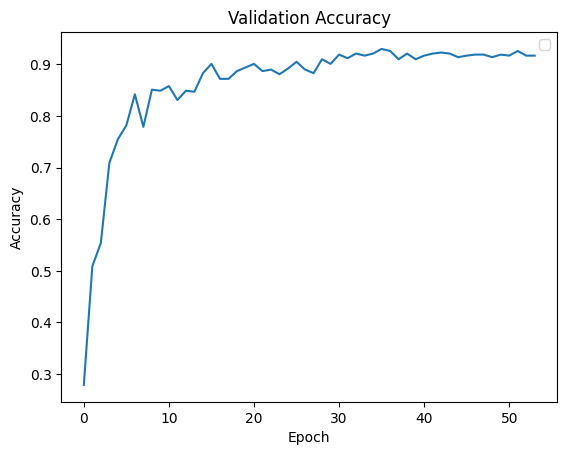

In [22]:
import matplotlib.pyplot as plt

plt.plot(val_acc)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
train_loss = [4.4948, 2.6659, 2.2678, 1.9149, 1.7388, 1.532, 1.4727, 1.3261, 1.3158, 1.2697, 1.1815, 1.1913, 1.1906, 1.1819, 1.158, 1.1365, 1.0984, 1.0433, 1.0485, 1.035, 1.0396, 1.0342, 0.9858, 1.0233, 1.0005, 1.007, 0.9373, 1.0785, 0.9402, 0.9428, 0.8604, 0.8319, 0.808, 0.8084, 0.8011, 0.7934, 0.7896, 0.7902, 0.7853, 0.7862, 0.7868, 0.7827, 0.7801, 0.7762, 0.7732, 0.7729, 0.7704, 0.7669, 0.7688, 0.7702, 0.7697, 0.7678, 0.765, 0.7683]
val_loss = [4.2209, 3.8897, 2.1688, 1.818, 1.5345, 1.6232, 1.4258, 1.5883, 1.5375, 1.4441, 1.2356, 1.4043, 1.4276, 1.3313, 1.2496, 1.1144, 1.1666, 1.2199, 1.1453, 1.1157, 1.1167, 1.159, 1.3194, 1.1578, 1.2645, 1.1853, 1.0904, 1.4443, 1.1588, 1.1453, 1.0381, 0.988, 0.9868, 1.0001, 0.9761, 0.9903, 0.9777, 0.993, 0.99, 0.9893, 0.99, 0.9774, 0.9792, 0.9962, 0.9931, 0.9725, 0.9847, 0.9726, 0.9858, 0.9742, 0.973, 0.9792, 0.9871, 0.9722]

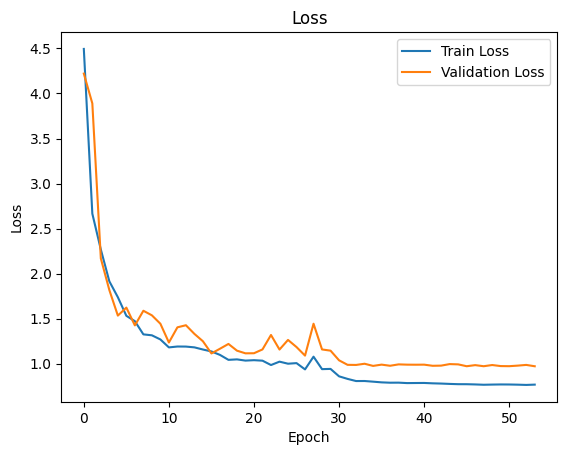

In [24]:
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()